[[0.4546509027413559, 0.0], [9.773680332260827, 175980.0]]
break
[0 0 1 0 0 0 1 0 0 0]
[[0.6506306124218265, 857.875], [9.20219876228041, 187590.5]]
0: 8
1: 2
sil: 0.996494344942213
discentroids: 186732.625


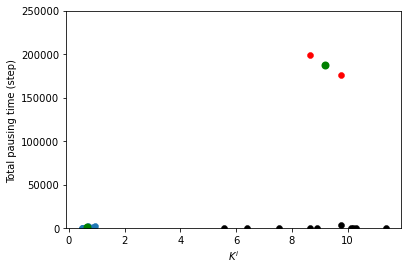

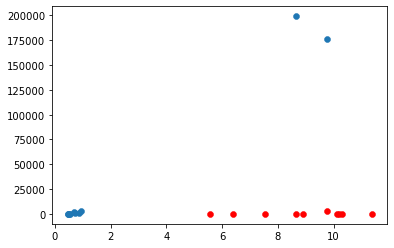

In [20]:
#補正係数と待機時間の散布図を出力するプログラム
import pandas as pd
import os
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing

#設定
robots_num = 20
#agent_type = "TimeChange"
agent_type = "OnebyOne"
#agent_type = "TimeChange_Learning"
target_type = "5-AMTDS-ESC"
#target_type = "6-Security"
#date = "05-12 05-21-18 robots-number=20_1"
#date = "07-13 17-06-04 robots-number=20_2"
#date = "08-07 00-56-34 robots-number=20_1"
date = "10-14 05-09-27 robots-number=20_1"
counter = 0
era = 11
time = era * 250000
before_time = 1
before_time = (era-1) * 250000
after_time = era * 250000
x = []
y = []
stop_agent_list = [2, 15, 8, 0, 9, 5, 17, 18, 10, 19]
#stop_agent_list = []
stop_number = len(stop_agent_list)
sx = []
sy = []
X = [[], []]
robot_num = 20
total = 0

env = "Complex"


def kmeans2(x, y, max_iter=300):
    k = 2
    centroids = [[min(x), y[x.index(min(x))]], [max(x), y[x.index(max(x))]]]
    print(centroids)
    new_centroids = [[0, 0], [0, 0]]
    distances = np.zeros(k)
    #print(centroids[0][0])
    size = len(x)
    
    cluster = np.zeros(size)
    
    for epoch in range(max_iter):
        for i in range(size):
            for j in range(k):
                distances[j] = (centroids[j][0] - x[i]) ** 2 + ((centroids[j][1] - y[i]) ** 2)
                
            if distances[0] <= distances[1]:
                cluster[i] = 0
            else:
                cluster[i] = 1
    
        new_centroids = [[0, 0], [0, 0]]
        for i in range(k):
            csize = 0
            for j in range(size):
                if cluster[j] == i:
                    csize += 1
                    new_centroids[i][0] += x[j]
                    new_centroids[i][1] += y[j]
                    
            #print(str(i) + ":" + str(csize))
            new_centroids[i][0] /= csize
            new_centroids[i][1] /= csize
            
        if new_centroids[0][0] == centroids[0][0] and new_centroids[0][1] == centroids[0][1]:
            print("break")
            break
        
        centroids = new_centroids
    
    return cluster, new_centroids


def calSil(x, y, cluster):
    clus = [0, 0] #各クラスターの数
    size = len(x)
    sil = np.zeros(size) #各エージェントのシルエット係数
    a = np.zeros(size) #凝集度
    b = np.zeros(size) #乖離度
    
    #各クラスターの数を計算
    for k in range(2):
        clus[k] = sum(cluster[i]==k for i in range(size))
        print(str(k) + ": " + str(clus[k]))
    
    for i in range(size):
        myclus = cluster[i]
        #print(myclus)
        #aとbの計算
        for j in range(size):
            if i == j:
                continue
            
            dis = (x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2
            
            #aの計算
            if cluster[j] == myclus:    
                a[i] += dis
            #bの計算
            else:
                b[i] += dis
                
                
        #aの計算
        if clus[myclus] == 1:
            a[i] = 0.0
        else:
            a[i] / (clus[myclus] - 1)
            
        #bの計算
        b[i] /= clus[1-myclus]
        
        #シルエット係数の計算
        sil[i] = (b[i] - a[i]) / max(a[i], b[i])
    
    #平均シルエット係数の計算
    ans = sum(sil) / size
    #print("a: " + str(sum(a)))
    return ans
    

for i in range(robots_num):
    df = pd.read_csv("../../../../Volumes/ExternalDisk1/Patrolling/log/OTest/" + agent_type + "/" + env + "/" + target_type + "/" + date + "/Agent" + str(i) + "/Correction.csv", names=['time', 'before', 'after', 'real', 'req'], header=None)
    count = df[df['time'] <= time].tail(1)['after'].item()
    
    df = pd.read_csv("../../../../Volumes/ExternalDisk1/Patrolling/log/OTest/" + agent_type + "/" + env + "/" + target_type + "/" + date + "/Agent" + str(i) + "/wait.csv", names=['time', 'battery', 'probability', 'waitTime'], header=None)
    before_count = df[df['time'] < before_time].sum()['waitTime'].item()
    #print(df[df['time'] < before_time].tail(1)['time'] + df[df['time'] < before_time].tail(1)['waitTime'].item())
    if (df[df['time'] < before_time].tail(1)['time'] + df[df['time'] < before_time].tail(1)['waitTime']).item() > before_time:
        before_count -= df[df['time'] < before_time].tail(1)['waitTime'].item()
        before_count += (before_time - df[df['time'] < before_time].tail(1)['time'].item())
    #print("before " + str(i) + ":" + str(before_count))
    
    after_count = df[df['time'] <= after_time].sum()['waitTime'].item()
    if (df[df['time'] <= after_time].tail(1)['time'] + df[df['time'] < after_time].tail(1)['waitTime']).item() > after_time:
        after_count -= df[df['time'] <= after_time].tail(1)['waitTime'].item()
        after_count += (after_time - df[df['time'] <= after_time].tail(1)['time'].item())
    #print("after " + str(after_count))
    
    res = after_count - before_count
    total += res
    
    if i in stop_agent_list:
        sx.append(count)
        sy.append(res)
    else:
        X[0].append(count)
        X[1].append(res)

cluster, centroids = kmeans2(X[0], X[1])
cluster = np.asarray(cluster, dtype=int)

print(cluster)
print(centroids)

sil = calSil(X[0], X[1], cluster)
print("sil: " + str(sil))

cx = [[], []]
cy = [[], []]
totalWait = 0
for i in range(len(X[0])):
    if cluster[i] == 0:
        cx[0].append(X[0][i])
        cy[0].append(X[1][i])
        totalWait += centroids[0][1]
    else:
        cx[1].append(X[0][i])
        cy[1].append(X[1][i])
        totalWait += centroids[1][1]
    
#print(total)
#print(totalWait)

print("discentroids: " + str(centroids[1][1] - centroids[0][1]))
    
plt.scatter(cx[0], cy[0], linewidths=0.5)
plt.scatter(centroids[0][0], centroids[0][1], linewidths=2.0, color="green")
plt.scatter(cx[1], cy[1], linewidths=0.5, color = "red")
plt.scatter(centroids[1][0], centroids[1][1], linewidths=2.0, color="green")
plt.scatter(sx, sy, linewidths=0.5, color="black")

#ラベルの追加
plt.xlabel('$K^i$')
plt.ylabel('Total pausing time (step) ')

#表示範囲の指定
#plt.xlim(0, 1.5)
plt.ylim(0, 250000)

#plt.xticks(np.arange(0, 5, 1))

#指数表記から普通の表記に変換
plt.ticklabel_format(style='plain',axis='y')

#フォルダがない場合は、作成
p_dir = pathlib.Path("../../../../Volumes/ExternalDisk1/Patrolling/result/correction_cluster")
if not p_dir.exists():
    p_dir.mkdir(parents=True)

#グラフの保存
plt.savefig(str(p_dir) + '/' + 'CorrectionCluster_' + date + '.png', bbox_inches="tight")

plt.show()



plt.scatter(X[0], X[1], linewidths=0.5)
plt.scatter(sx, sy, linewidth=0.5, color="red")
plt.show()